This notebook is used to evaluate the hyperparameter tuned random forest models; outputs auc_roc plot, probability histograms

In [1]:
import pandas as pd
import seaborn as sns

In [2]:
#!pip install seaborn

In [3]:
#load data
#load df
segment = 'test'
#X = pd.read_csv(f'./Wrangled_Data/wrangled_{segment}.csv')

In [4]:
#jied
def RF_model_builder2(n_estimators = 100,
                    criterion = 'gini',
                    max_depth = None,
                    min_samples_split = 2,
                    min_samples_leaf = 1,
                    max_features = 'sqrt',
                    max_leaf_nodes = None,
                    min_weight_fraction_leaf = 0.0,
                    random_state = 42
                     ):
    
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(n_estimators = n_estimators, 
                                   criterion = criterion,
                                   max_depth = max_depth, 
                                   min_samples_split = min_samples_split, 
                                   min_samples_leaf = min_samples_leaf, 
                                   max_features = max_features, 
                                   max_leaf_nodes = max_leaf_nodes,
                                   min_weight_fraction_leaf = min_weight_fraction_leaf,
                                   random_state = 42)
    return model

In [5]:
#X.columns

In [6]:
#define function that onehot encodes, models Random Forest, and gives out AUC
def RF_ohe_model_auc(cleaned_df, rf_model,segment=segment):
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.impute import SimpleImputer
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.metrics import mean_absolute_error
    import pandas as pd
    import numpy as np
    from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc
    from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score
    #from catboost.utils import get_confusion_matrix, get_roc_curve, get_fnr_curve, get_fpr_curve
    from sklearn.metrics import RocCurveDisplay
    from sklearn import metrics
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    #load df
    X_full = cleaned_df.copy()

    #remove rows with missing target: D3_within12months, loan_account_no
    X_full.dropna(axis=0, subset=['D3_within12months'], inplace=True)
    y = X_full.D3_within12months
    X_full.drop(['D3_within12months', 'loan_account_no'], axis=1, inplace=True)

    from sklearn.model_selection import train_test_split
    X_train_full, X_test_full, y_train, y_test = train_test_split(X_full, y, 
                                                                   train_size=0.8, test_size=0.2,
                                                                   random_state=11, stratify = y)

    #select categorical columns
    categorical_cols = [cname for cname in X_train_full.columns if
                       X_train_full[cname].dtype == "object"]

    numerical_cols = [cname for cname in X_train_full.columns if
                     X_train_full[cname].dtype in ['int64', 'float64']]

    #keep selected columns only
    my_cols = categorical_cols + numerical_cols
    X_train = X_train_full[my_cols].copy()
    X_test = X_test_full[my_cols].copy()


    #preprocess numerical data
    numerical_transformer = SimpleImputer(strategy='constant')

    #preprocessing categorical data
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore',drop='first'))
    ])

    #Bundle preprocessing for num and categ data
    preprocessor = ColumnTransformer(
        transformers=[
            ('num',numerical_transformer,numerical_cols),
            ('cat',categorical_transformer,categorical_cols)
        ]
    )

    model = rf_model

    #Bundle preprocessing and modeling code in a pipeline
    clf = Pipeline(steps=[('preprocessor',preprocessor),
                         ('model', model)
                         ])

    #preprocessing of training data, fit model
    clf.fit(X_train, y_train)

    y_pred_proba = clf.predict_proba(X_test)[:,1]

    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred_proba)
    
    #compute optimal threshold based on roc_auc curve only
    opt = true_positive_rate - false_positive_rate
    tp_fp_diff = pd.DataFrame({'thresholds': threshold, 'tpr_fpr': opt})

    max_index = tp_fp_diff.tpr_fpr.argmax()
    THRESHOLD = tp_fp_diff.iloc[max_index][0]
    
    y_pred = np.where(y_pred_proba > THRESHOLD, 1, 0)

    plt.subplots(1, figsize = (5,5))
    luh = roc_auc_score(y_test, y_pred_proba)
    plt.title(f'ROC_AUC Curve: {luh:.2f}')
    plt.plot(false_positive_rate, true_positive_rate)
    plt.plot([0,1], ls = "--")
    plt.plot([0,0],[1,0], c= ".7"), plt.plot([1,1], c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    print(classification_report(y_test, y_pred, target_names = ['Good Customer','Bad Customer']))
    cnf_matrix = metrics.confusion_matrix(y_test,y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(cnf_matrix)
    print(tn, fp, fn, tp)
    
    sns.distplot(y_pred_proba)
    plt.show()
    
    feat_importances = clf.named_steps['model'].feature_importances_
    feature_names = clf.named_steps['preprocessor'].get_feature_names_out()

    feat_imp_df = pd.DataFrame({
        'variable':feature_names,
        'feature_importances':feat_importances
    })
    
    feat_imp_df.to_csv(f'./Feature_Importance/featimportance_RF_{segment}.csv', index=False)

    feat_imp_df = feat_imp_df.sort_values(by='feature_importances', ascending=False)
    print(feat_imp_df[:20])

C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_11720\3752324747.py:80: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  THRESHOLD = tp_fp_diff.iloc[max_index][0]


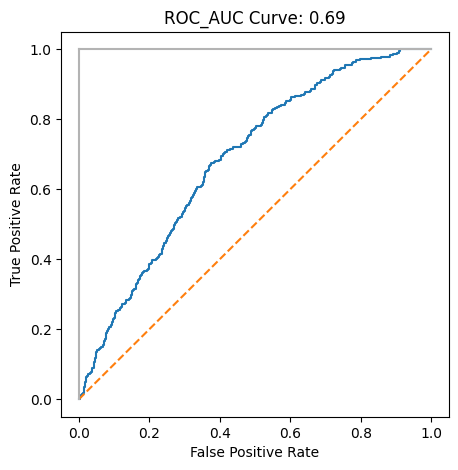

C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_11720\3752324747.py:100: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred_proba)


               precision    recall  f1-score   support

Good Customer       0.95      0.62      0.75      3336
 Bad Customer       0.15      0.67      0.24       320

     accuracy                           0.63      3656
    macro avg       0.55      0.65      0.50      3656
 weighted avg       0.88      0.63      0.71      3656

[[2082 1254]
 [ 105  215]]
2082 1254 105 215


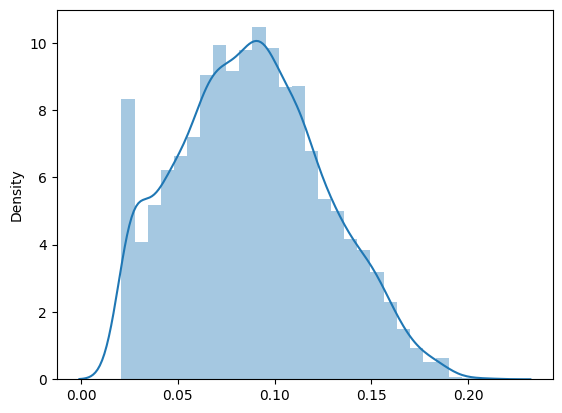

                               variable  feature_importances
2              num__down_payment_amount             0.159263
10                        num__dp_ratio             0.149014
5           num__number_of_installments             0.142091
49       cat__res_state_grp_MAHARASHTRA             0.058004
6                  num__loan_asset_cost             0.044213
1                              num__age             0.042258
4                    num__interest_rate             0.039926
9                   num__monthly_income             0.033376
28               cat__branch_grp_OTHERS             0.033092
45             cat__res_city_grp_MUMBAI             0.030913
52  cat__res_resident_status_grp_RENTED             0.026974
7     num__res_years_at_current_address             0.026852
3                     num__total_income             0.026167
0        num__res_years_at_current_city             0.018847
48         cat__res_state_grp_KARNATAKA             0.016434
25            cat__branc

In [9]:
#ntc tuned randomgridsearchcv
rf_NTC_vf = RF_model_builder2(n_estimators = 58,
                    criterion = 'gini',
                    max_depth = 9,
                    min_samples_split = 2,
                    min_samples_leaf = 45,
                    max_features = 'sqrt',
                    max_leaf_nodes = 24,
                    min_weight_fraction_leaf = 0.007818203370596966,
                    random_state = 42)
segment = 'NTC'
X = pd.read_csv(f'./Wrangled_Data/wrangled_{segment}.csv')
RF_ohe_model_auc(X, rf_NTC_vf)

C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_11720\3752324747.py:80: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  THRESHOLD = tp_fp_diff.iloc[max_index][0]


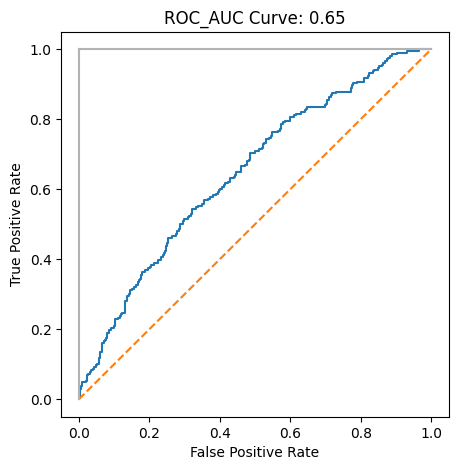

C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_11720\3752324747.py:100: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred_proba)


               precision    recall  f1-score   support

Good Customer       0.94      0.68      0.79      2068
 Bad Customer       0.14      0.54      0.23       206

     accuracy                           0.67      2274
    macro avg       0.54      0.61      0.51      2274
 weighted avg       0.86      0.67      0.74      2274

[[1402  666]
 [  95  111]]
1402 666 95 111


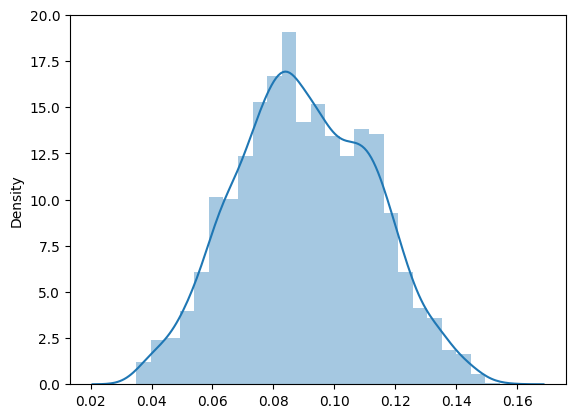

                               variable  feature_importances
5           num__number_of_installments             0.136481
10                        num__dp_ratio             0.132721
2              num__down_payment_amount             0.120772
1                              num__age             0.119060
6                  num__loan_asset_cost             0.045948
45             cat__res_city_grp_MUMBAI             0.039144
49       cat__res_state_grp_MAHARASHTRA             0.036449
32                cat__branch_grp_VIRAR             0.035490
7     num__res_years_at_current_address             0.033356
0        num__res_years_at_current_city             0.029880
52  cat__res_resident_status_grp_RENTED             0.026080
48         cat__res_state_grp_KARNATAKA             0.021397
9                   num__monthly_income             0.019787
3                     num__total_income             0.019718
4                    num__interest_rate             0.018883
15           cat__marita

In [10]:
#low_CIBIL tuned randomgridsearchcv
rf_low_CIBIL_vf = RF_model_builder2(n_estimators = 493,
                    criterion = 'entropy',
                    max_depth = 5,
                    min_samples_split = 7,
                    min_samples_leaf = 158,
                    max_features = 'log2',
                    max_leaf_nodes = 353,
                    min_weight_fraction_leaf = 0.00038938292050716417,
                    random_state = 42)
segment = 'low_CIBIL'
X = pd.read_csv(f'./Wrangled_Data/wrangled_{segment}.csv')
RF_ohe_model_auc(X, rf_low_CIBIL_vf, segment)

C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_11720\3752324747.py:80: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  THRESHOLD = tp_fp_diff.iloc[max_index][0]


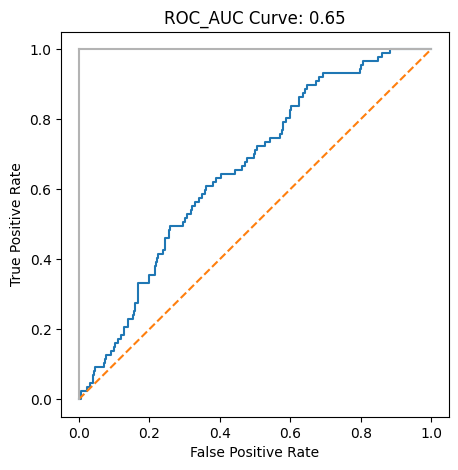

C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_11720\3752324747.py:100: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred_proba)


               precision    recall  f1-score   support

Good Customer       0.98      0.35      0.52      1398
 Bad Customer       0.08      0.89      0.14        87

     accuracy                           0.38      1485
    macro avg       0.53      0.62      0.33      1485
 weighted avg       0.93      0.38      0.50      1485

[[492 906]
 [ 10  77]]
492 906 10 77


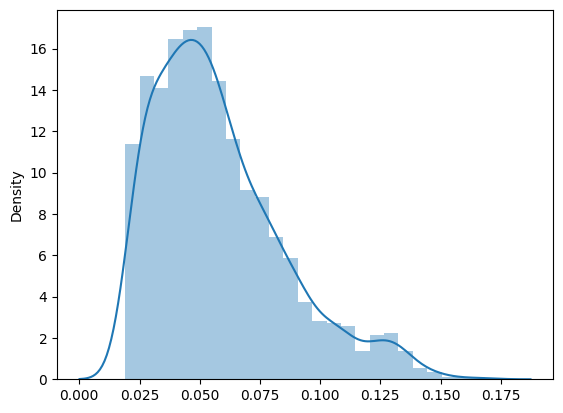

                               variable  feature_importances
2              num__down_payment_amount             0.131098
10                        num__dp_ratio             0.130726
1                              num__age             0.093450
48         cat__res_state_grp_KARNATAKA             0.065236
6                  num__loan_asset_cost             0.060114
9                   num__monthly_income             0.053711
3                     num__total_income             0.045500
52  cat__res_resident_status_grp_RENTED             0.042396
7     num__res_years_at_current_address             0.035713
5           num__number_of_installments             0.034263
0        num__res_years_at_current_city             0.031794
49       cat__res_state_grp_MAHARASHTRA             0.031367
29      cat__branch_grp_SOUTH_BANGALORE             0.021603
4                    num__interest_rate             0.018144
17     cat__nature_of_business_SERVICES             0.017017
28               cat__br

In [11]:
#mid_CIBIL tuned randomgridsearchcv
rf_mid_CIBIL_vf = RF_model_builder2(n_estimators = 58,
                    criterion = 'gini',
                    max_depth = 9,
                    min_samples_split = 2,
                    min_samples_leaf = 45,
                    max_features = 'sqrt',
                    max_leaf_nodes = 24,
                    min_weight_fraction_leaf = 0.007818203370596966,
                    random_state = 42)

segment = 'mid_CIBIL'
X = pd.read_csv(f'./Wrangled_Data/wrangled_{segment}.csv')
RF_ohe_model_auc(X, rf_mid_CIBIL_vf, segment)

C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_11720\3752324747.py:80: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  THRESHOLD = tp_fp_diff.iloc[max_index][0]


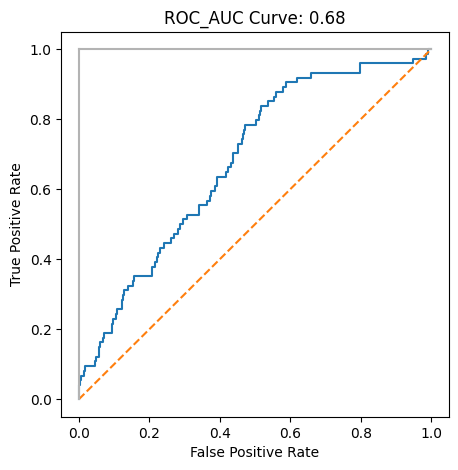

C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_11720\3752324747.py:100: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred_proba)


               precision    recall  f1-score   support

Good Customer       0.99      0.48      0.65      2448
 Bad Customer       0.05      0.82      0.09        74

     accuracy                           0.49      2522
    macro avg       0.52      0.65      0.37      2522
 weighted avg       0.96      0.49      0.63      2522

[[1185 1263]
 [  13   61]]
1185 1263 13 61


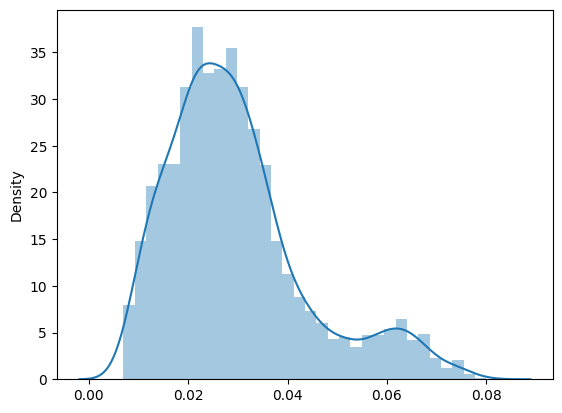

                               variable  feature_importances
2              num__down_payment_amount             0.128168
10                        num__dp_ratio             0.126976
48         cat__res_state_grp_KARNATAKA             0.080168
5           num__number_of_installments             0.078524
52  cat__res_resident_status_grp_RENTED             0.076306
1                              num__age             0.056929
49       cat__res_state_grp_MAHARASHTRA             0.054397
4                    num__interest_rate             0.038626
6                  num__loan_asset_cost             0.031152
29      cat__branch_grp_SOUTH_BANGALORE             0.031111
0        num__res_years_at_current_city             0.026260
45             cat__res_city_grp_MUMBAI             0.026162
7     num__res_years_at_current_address             0.025739
28               cat__branch_grp_OTHERS             0.024803
30             cat__branch_grp_S_MUMBAI             0.023558
32                cat__b

In [12]:
#high_CIBIL tuned randomgridsearchcv
rf_high_CIBIL_vf = RF_model_builder2(n_estimators = 493,
                    criterion = 'entropy',
                    max_depth = 5,
                    min_samples_split = 7,
                    min_samples_leaf = 158,
                    max_features = 'log2',
                    max_leaf_nodes = 353,
                    min_weight_fraction_leaf = 0.00038938292050716417,
                    random_state = 42)
segment = 'high_CIBIL'
X = pd.read_csv(f'./Wrangled_Data/wrangled_{segment}.csv')
RF_ohe_model_auc(X, rf_high_CIBIL_vf, segment)